In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn. metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import seaborn as sns; sns.set()
import joblib
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
from pathlib import Path
import copy

#Trying out recusive feature elimination to compare with step wise regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import sklearn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

from progressbar import ProgressBar


from os import listdir
from os.path import isfile, join
import datetime
import calendar


%matplotlib inline

#custom functions
def NSC(y_pred,y_true):
    """
    Nash-Sutcliffe Coefficient
    """
    return 1 - sum((y_pred-y_true)**2)/sum((y_true-np.mean(y_true))**2)

def corr(data1, data2):
    "data1 & data2 should be numpy arrays."
    mean1 = data1.mean() 
    mean2 = data2.mean()
    std1 = data1.std()
    std2 = data2.std()

#     corr = ((data1-mean1)*(data2-mean2)).mean()/(std1*std2)
    corr = ((data1*data2).mean()-mean1*mean2)/(std1*std2)
    return corr


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:

#This is the final dataset to make predictions on
p = Path('C:/Users/Ryan/Box/Dissertation/Paper1/Data/Processed_Training_Data')
#dir_data = 'C:/Users/Ryan/Box/Dissertation/Paper1/Data/Model_Input_Data/Monthly/Input/FinalVars'

slc = {i.stem[0:3] : pd.read_excel(i) for i in p.glob('**/*.xlsx')}

#rename the gpcd column
for i in slc:
    slc[i].rename(columns={i+'_gpcd': 'Obs_gpcd'}, inplace=True)
    slc[i]=slc[i].set_index('Year')
snow=pd.read_excel('C:/Users/Ryan/Box/Dissertation/Paper1/Data/Alta_LCC_snow.xlsx')
snow=snow.set_index('Year')



In [3]:
#Create training and testing data, use most recent low, average, and high water years
slc_train=copy.deepcopy(slc)
slc_test=copy.deepcopy(slc)

#2008 is a high year
#2011 and 2017 are average years
#2014 and 2016 are below average years
#2015 is a very  low year

IN_WY_Months = ['Jan' , 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug','Sep', 'Oct']
Prior_YR_WY_Months = ['Nov', 'Dec']
testWYyrs = [2008,2015,2017]
#testPrioWYyrs = [2007,2014,2016]


for i in slc:
    #Select the training/testing dataframes
    slc_train[i]=slc_train[i][~slc_train[i].index.isin(testWYyrs)]
    slc_test[i]=slc_test[i][slc_test[i].index.isin(testWYyrs)]
   
    


In [4]:
#Create training and testing data
#slc_train=copy.deepcopy(slc)
#slc_test=copy.deepcopy(slc)

#Train_yrs= 26
#

#for i in slc:
    #Select the training/testing dataframes
 #   slc_train[i]=slc_train[i][:Train_yrs]
  #  slc_test[i]=slc_test[i][Train_yrs:]

In [5]:
    

#Determine the indoor mean to subtract from outdoor
I_mean_train=(slc_train['Jan']['Obs_gpcd']+
              slc_train['Feb']['Obs_gpcd']+
              slc_train['Mar']['Obs_gpcd']+
              slc_train['Nov']['Obs_gpcd']+
             slc_train['Dec']['Obs_gpcd'])/5
I_mean_test=(slc_test['Jan']['Obs_gpcd']+
             slc_test['Feb']['Obs_gpcd']+
             slc_test['Mar']['Obs_gpcd']+
             slc_test['Nov']['Obs_gpcd']+
             slc_test['Dec']['Obs_gpcd'])/5
#This uses total demand for irrigation seasons
#I_mean_train=np.zeros(23)
#I_mean_test=np.zeros(10)

for i in slc_train:
    slc_train[i]['Iave']=I_mean_train
    #for now include testing years
    slc_test[i]['Iave']=I_mean_test

IrrSeason= ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']
Indoor=['Jan', 'Feb', 'Mar', 'Nov', 'Dec']
colrem=['Iave', 'Obs_gpcd']
#set the target gpcd to indoor for indoor and total-indoor for outdoor
#change to indoor to separate outdoor demands from total
for i in Indoor:
    slc_train[i]['Target_gpcd']=slc_train[i]['Obs_gpcd']
    slc_train[i]= slc_train[i].drop(columns=colrem)
    #for now include testing years
    slc_test[i]['Target_gpcd']=slc_test[i]['Obs_gpcd']
    slc_test[i]= slc_test[i].drop(columns=colrem)
    

#Establish outdoor conservation thresholds
O_cons = 0.25
time = 20


for i in IrrSeason:
    slc_train[i]['Target_gpcd']=slc_train[i]['Obs_gpcd']-slc_train[i]['Iave']
    slc_train[i].loc[slc_train[i]['Target_gpcd'] < 0, 'Target_gpcd'] = 0
    
    #add in snow info
    slc_train[i]=pd.concat([slc_train[i], snow], axis=1, join="inner")
    
    slc_train[i]= slc_train[i].drop(columns=colrem)
    #for now include testing years
    slc_test[i]=pd.concat([slc_test[i], snow], axis=1, join="inner")
    slc_test[i]['Target_gpcd']=slc_test[i]['Obs_gpcd']-slc_test[i]['Iave']
    slc_test[i].loc[slc_test[i]['Target_gpcd'] < 0, 'Target_gpcd'] = 0
    
    #create monthly historical mean and conservation trends
    Out_mean = np.mean(slc_train[i]['Target_gpcd'].loc[2000:])
    goal = (1-O_cons)*Out_mean
    O_cons_rate = (Out_mean -goal)/time
    


    slc_train[i]['cons_goal'] = Out_mean- ((slc_train[i].index-2000)*O_cons_rate)
    slc_train[i].loc[ slc_train[i].index <2000, ['cons_goal']] = Out_mean
    
    t=slc_train[i]['Target_gpcd'].copy()
    c=slc_train[i]['cons_goal'].copy()
    slc_train[i] = slc_train[i].drop(columns=['Target_gpcd', 'cons_goal'])
    slc_train[i]['Target_gpcd'] = t
    slc_train[i]['cons_goal'] = c
    
    slc_test[i]['cons_goal'] = Out_mean - ((slc_test[i].index-2000)*O_cons_rate) 
    
 
    
    
    slc_test[i]= slc_test[i].drop(columns=colrem)

    
#Determine the historical indoor mean to apply conservation strategies too
Indmean = np.mean(slc_train['Jan']['Target_gpcd'].loc[2000:]+
                  slc_train['Feb']['Target_gpcd'].loc[2000:]+
                  slc_train['Mar']['Target_gpcd'].loc[2000:]+
                  slc_train['Nov']['Target_gpcd'].loc[2000:]+
                 slc_train['Dec']['Target_gpcd'].loc[2000:])/5
'''Per UDWR 2001, Utah's Water Resources: Planning for the future, the govenor ordered a
25% reduction in water use by 2025
'''
cons = 0.28

goal = (1-cons)*Indmean

time = 20

cons_rate = (Indmean -goal)/time

#print(cons_rate , goal)

#create feature called cons_goal!
for i in Indoor:
    slc_test[i]['cons_goal'] = Indmean-((slc_test[i].index-2000)*cons_rate) 
    slc_train[i]['cons_goal'] = Indmean-((slc_train[i].index-2000)*cons_rate) 
    
    slc_train[i].loc[ slc_train[i].index <2000, ['cons_goal']] = Indmean
    
    
Cons_mean_test=(slc_test['Jan']['cons_goal']+
                slc_test['Feb']['cons_goal']+
                slc_test['Mar']['cons_goal']+
                slc_test['Nov']['cons_goal']+
                slc_test['Dec']['cons_goal'])/5

#split training and testing data into features and targets
slc_train_target=copy.deepcopy(slc_train)
slc_train_features=copy.deepcopy(slc_train)

slc_test_target=copy.deepcopy(slc_test)
slc_test_features=copy.deepcopy(slc_test)


target=['Target_gpcd','Housing']
for i in slc_train_target:
    slc_train_target[i]=slc_train_target[i]['Target_gpcd']
    #for now include testing years
    slc_test_target[i]=slc_test_target[i]['Target_gpcd']


    slc_train_features[i]= slc_train_features[i].drop(columns=target)
    #for now include testing years
    slc_test_features[i]= slc_test_features[i].drop(columns=target)
    
#need to remove year from the list to run plots below
for i in slc_train:
    slc_train[i]=slc_train[i].drop(columns=['Housing',  'Population', 'PopulationDensity'])


In [6]:
#Use features from MLR 

Apr = ['Val_Apr_Monthly_mean_Day_temp_C', 'Val_Apr_Monthly_precip_mm', 'LitCotCrk_AcFt_WR_Apr',
       'LitCotCrk_AcFt_WR_Mar', 'Target_gpcd']
May = ['Val_May_Monthly_precip_mm', 'Val_May_Monthly_mean_Day_temp_C', 'Target_gpcd']
Jun = ['Val_Jun_Monthly_precip_mm', 'Val_Apr_Monthly_mean_Day_temp_C', 'BigCotCrk_AcFt_WR_Jun', 
       'Val_May_Monthly_mean_Day_temp_C', 'CityCrk_AcFt_WR_May', 'BigCotCrk_AcFt_WR_May', 
       'Val_May_Monthly_precip_mm', 'Target_gpcd']
Jul = ['UrbPopulationDensity', 'Val_Jul_Monthly_mean_Day_temp_C', 'Val_Apr_Monthly_mean_Day_temp_C',
       'Val_May_Monthly_mean_Day_temp_C', 'Target_gpcd']
Aug = ['Val_Aug_Monthly_precip_mm', 'UrbPopulationDensity', 'LitCotCrk_AcFt_WR_Apr',
       'Val_Apr_Monthly_mean_Day_temp_C', 'Val_Aug_Monthly_mean_Day_temp_C', 'LitCotCrk_AcFt_WR_Mar', 
       'Val_Apr_Monthly_precip_mm', 'Val_May_Monthly_mean_Day_temp_C', 'Val_Jul_Monthly_mean_Day_temp_C', 
       'Val_Jun_Monthly_mean_Day_temp_C', 'Val_Jun_Monthly_precip_mm', 'BigCotCrk_AcFt_WR_May',
       'LitCotCrk_AcFt_WR_May', 'Target_gpcd']
Sep = ['Val_Sep_Monthly_precip_mm', 'Val_Sep_Monthly_mean_Day_temp_C', 'Val_Aug_Monthly_mean_Day_temp_C', 
       'Val_May_Monthly_mean_Day_temp_C', 'Val_Apr_Monthly_mean_Day_temp_C', 'Val_Jun_Monthly_mean_Day_temp_C',
       'Val_Jul_Monthly_mean_Day_temp_C', 'Target_gpcd']
Oct = ['cons_goal','Target_gpcd']


#select these features for training and testing
slc_train['Apr'] = slc_train['Apr'][Apr]
slc_test['Apr'] = slc_test['Apr'][Apr]

slc_train['May'] = slc_train['May'][May]
slc_test['May'] = slc_test['May'][May]

slc_train['Jun'] = slc_train['Jun'][Jun]
slc_test['Jun'] = slc_test['Jun'][Jun]

slc_train['Jul'] = slc_train['Jul'][Jul]
slc_test['Jul'] = slc_test['Jul'][Jul]

slc_train['Aug'] = slc_train['Aug'][Aug]
slc_test['Aug'] = slc_test['Aug'][Aug]

slc_train['Sep'] = slc_train['Sep'][Sep]
slc_test['Sep'] = slc_test['Sep'][Sep]

slc_train['Oct'] = slc_train['Oct'][Oct]
slc_test['Oct'] = slc_test['Oct'][Oct]

In [7]:
def model_plots(PerfDF, month):
    plt.rcParams["axes.grid"] = False
    plt.rcParams["axes.facecolor"] ='white'
    plotmin = PerfDF[['y_pred', 'y_test']].min().min()
    plotmax = PerfDF[['y_pred', 'y_test']].max().max()
    
    plotmin_tot = PerfDF[['y_pred_tot', 'y_test_tot']].min().min()
    plotmax_tot = PerfDF[['y_pred_tot', 'y_test_tot']].max().max()
    
    
    fig, ax = plt.subplots(3,2, constrained_layout=True)
    fig.set_size_inches(9,10)

    ax[0,0].scatter(PerfDF['y_test'], PerfDF['y_pred'],color='blue', alpha=0.5)
    ax[0,0].set_ylabel('Predicted')
    ax[0,0].set_xlabel('Observed')
    ax[0,0].set_ylim(plotmin-5,plotmax+5)
    ax[0,0].set_xlim(plotmin-5,plotmax+5)
    ax[0,0].set_title('Outdoor Model Performance')
    ax[0,0].plot([plotmin,plotmax],[plotmin,plotmax], color='red', linestyle='--' )
    ax[0,0].spines['bottom'].set_color('black')
    ax[0,0].spines['left'].set_color('black')
    
    ax[0,1].scatter(PerfDF['y_test_tot'], PerfDF['y_pred_tot'],color='blue', alpha=0.5)
    ax[0,1].set_ylabel('Predicted')
    ax[0,1].set_xlabel('Observed')
    ax[0,1].set_ylim(plotmin_tot-5,plotmax_tot+5)
    ax[0,1].set_xlim(plotmin_tot-5,plotmax_tot+5)
    ax[0,1].set_title('Indoor and Outdoor \n Model Performance')
    ax[0,1].plot([plotmin_tot,plotmax_tot],[plotmin_tot,plotmax_tot], color='red', linestyle='--' )
    ax[0,1].spines['bottom'].set_color('black')
    ax[0,1].spines['left'].set_color('black')

    
    
    
    gs = ax[1, 1].get_gridspec()
    # remove the underlying axes
    ax[1,0].remove()
    ax[1,1].remove()

    PerfDF['Error'] = (PerfDF['y_pred']-PerfDF['y_test'])
    axbig1 = fig.add_subplot(gs[1, :])
    axbig1.set_title(month+' Outdoor demand Timeline Evaluation')
    axbig1.axhline(y = 0 , color = 'black')
    #axbig1.bar(PerfDF.index, PerfDF['y_pred'], color='orange', label='Predicted')
    Error1 = axbig1.bar(PerfDF.index, PerfDF['Error'],color='blue', label='Prediction Error')
    axbig1.set_xlabel('Year')
    axbig1.set_ylabel('Error (GPCD)')
    axbig1.spines['bottom'].set_color('black')
    axbig1.spines['left'].set_color('black')
    gradientbars_sliced(Error1)
    
    
    gs2 = ax[2, 1].get_gridspec()
    # remove the underlying axes
    ax[2,0].remove()
    ax[2,1].remove()


    #create error value
    PerfDF['Error_tot'] = (PerfDF['y_pred_tot']-PerfDF['y_test_tot'])
    
    axbig2 = fig.add_subplot(gs2[2, :])
    axbig2.set_title(month+' Total Demand Error Timeline Evaluation')
    Error2 = axbig2.bar(PerfDF.index, PerfDF['Error_tot'], color='blue', label='Predicted')
    axbig2.axhline(y = 0 , color = 'black')
    #axbig2.bar(PerfDF.index, PerfDF['y_test_tot'],color='blue', label='Observed')
    axbig2.set_xlabel('Year')
    axbig2.set_ylabel('Error (GPCD)')
    axbig2.spines['bottom'].set_color('black')
    axbig2.spines['left'].set_color('black')
    gradientbars_sliced(Error2)
    
    fig.suptitle(month+ ' Evaluation', size = 16)
    fig.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/RFR' + month + '_demand.pdf')    
    
    O_r2 = sklearn.metrics.r2_score(PerfDF['y_test'],PerfDF['y_pred'])
    O_rmse= sklearn.metrics.mean_squared_error(PerfDF['y_test'],PerfDF['y_pred'], squared = False)
    O_mae= sklearn.metrics.mean_absolute_error(PerfDF['y_test'],PerfDF['y_pred'])
    O_mape= sklearn.metrics.mean_absolute_percentage_error(PerfDF['y_test'],PerfDF['y_pred'])
    
    T_r2 = sklearn.metrics.r2_score(PerfDF['y_test_tot'],PerfDF['y_pred_tot'])
    T_rmse= sklearn.metrics.mean_squared_error(PerfDF['y_test_tot'],PerfDF['y_pred_tot'], squared = False)
    T_mae= sklearn.metrics.mean_absolute_error(PerfDF['y_test_tot'],PerfDF['y_pred_tot'])
    T_mape= sklearn.metrics.mean_absolute_percentage_error(PerfDF['y_test_tot'],PerfDF['y_pred_tot'])
    
    print('The outdoor Demand prediction RMSE is ', O_rmse)
    print('The outdoor Demand prediction R2 is ', O_r2)
    
    print('The Total Demand prediction RMSE is ', T_rmse)
    print('The Total Demand prediction R2 is ', T_r2)
    print('The Total Demand prediction MAE is ', T_mae)
    print('The Total Demand prediction MAPE is ', T_mape, '%')     
  
    #set DF up so that all months can be easily combined, basically year-month index

In [8]:
def Indoor_Demand_Model(df, month):
    #Make matching indoor demand model
    datetime_object = datetime.datetime.strptime(month, "%b")
    df[month]['month'] = datetime_object.month
    
    df[month]['Year']=df[month].index
    
     #set up dates so all months can be combined and sorted
    day=[]
    for index, row in df[month].iterrows():
        day.append(calendar.monthrange(int(row['Year']), int(row['month']))[1])
    
    df[month]['Day']=day
    
  
    df[month]['Date'] = pd.to_datetime(df[month][['Year', 'month', 'Day']])
    
    #PerfDF=PerfDF.set_index('Date')
    df[month]=df[month].drop(columns=['month', 'Day'])
    df[month]=df[month].reset_index(drop=True)
   
    
    colrem = slc_test[i].columns
    df[month]['y_pred'] =  df[month]['cons_goal']
    df[month]['y_test'] =  df[month]['Target_gpcd']
    df[month]['y_pred_tot'] =  df[month]['cons_goal']
    df[month]['y_test_tot'] =  df[month]['Target_gpcd']
       
    df[month] = df[month].set_index('Date')
    
    df[month] = df[month].drop(columns=colrem)
    
    return df

In [9]:
#make a model function to determine best parameters
#Xt, yt are training features, training targets
def fit_model(X_train, y_train):
  
  #model dictionary and hyper-params to search over
    model = {}
    model['RandomForestRegressor'] = [RandomForestRegressor(), {'n_estimators':np.arange(5,75,5),
                                                                'criterion' : ['mse'],
                                                                'max_depth':np.arange(2,40,2),
                                                                'max_features': [0.2, 0.4, 0.5, 0.6, 0.8],
                                                                'bootstrap':['False'],
                                                                'oob_score':['True'],
                                                                'random_state':[42],
                                                                'n_jobs': [-1]
                                                                   }] 
  #Loop over models, hyper-params, and tune with cross validation    
    pbar = ProgressBar()
    for i in pbar(model.keys()):
        clf = GridSearchCV(model[i][0], model[i][1], n_jobs = -1, cv = 5)
        GS = clf.fit(X_train,y_train)
        model[i].append(GS)
        clf_b = model[i][2].best_estimator_
    print(clf_b)
    return clf_b

In [10]:
'''
The MLP model needs to take in normalized numpy arrays. The MLP Water Demand Model needs to:
1) take in all of the data (training and testing)
2) normalize that months training and testing inputs (0-1)
3) train and save the model, RFR_Models/
4) predict on testing dataset
5) convert to original units
6) Deliver prediction datastat (with orginial testing data) to send to figure generator.
'''

def RFR_OutdoorDemandModel(df_train, df_test,month, checkpointfilename):
    print(month, " Random Forest model training and calibration")
    
    traindf = df_train.copy()
    testdf = df_test.copy()
    
    #find the min of input data
    dfmin = traindf.append(testdf).copy()
    dfmin = list(dfmin.min())

    #normalize process A
    traindf = traindf-dfmin
    testdf = testdf-dfmin
      
    #find the min of input data
    dfmax = traindf.append(testdf).copy()
    dfmax = list(dfmax.max())

    #normalize process A
    traindf = traindf/dfmax
    testdf = testdf/dfmax
    
    #separate into training and testing features and targets
    features_tr = traindf.drop(columns =['Target_gpcd']).copy()
    features_val = testdf.drop(columns =['Target_gpcd']).copy()
    
    target_tr = traindf['Target_gpcd'].copy()
    target_val = testdf['Target_gpcd'].copy()
    
    #convert to numpy array for model
    features_tr = np.array(features_tr.to_numpy())
    features_val = np.array(features_val.to_numpy())
    
    target_tr_ = np.array(target_tr.to_numpy())
    target_val = np.array(target_val.to_numpy())
    
    #we want a y_test for later on too
    y_test = (target_val.copy()*dfmax[-1])+dfmin[-1]
   
    
    
    #Get the numpy shape for the model
    shape = features_tr.shape

    
    #now input the model
    model = fit_model(features_tr, target_tr)
    joblib.dump(model, checkpointfilename + '/'+ month + '/RFR_Demand_model.pkl') 
    
    #Make predictions on the validation data
    y_pred = model.predict(features_val)
    #make sure no negative values
   # y_pred = [0 if x < 0 else x for x in y_pred]
    
    #convert predictions to gpcd and place into OG dataframe
    y_pred = (y_pred*dfmax[-1])+dfmin[-1]
    shape = y_pred.shape
    y_pred = y_pred.reshape(shape[0])
    #measure the modeling performance of the MLP model
    O_r2_test = sklearn.metrics.r2_score(y_test, y_pred)
    O_rmse_test = sklearn.metrics.mean_squared_error(y_test, y_pred, squared = False)
    print('Outdoor R2 is ', O_r2_test)
    print('Outdoor RMSE is ', O_rmse_test)
        
    #put df in same format as MLR model
    PerfDF=pd.DataFrame(list(zip(y_pred, y_test)), columns=['y_pred', 'y_test'])

#Add indoor demands
    Indoor=['Jan', 'Feb', 'Mar', 'Nov', 'Dec']
    if month in Indoor:
        PerfDF['y_test']=PerfDF['y_test']
        PerfDF['y_pred']=PerfDF['y_pred']
    else:
        PerfDF['y_test_tot']=PerfDF['y_test']+list(I_mean_test)
        PerfDF['y_pred_tot']=PerfDF['y_pred']+list(Cons_mean_test)

    T_r2 = sklearn.metrics.r2_score(PerfDF['y_test_tot'], PerfDF['y_pred_tot'])
    T_rmse= sklearn.metrics.mean_squared_error(PerfDF['y_test_tot'], PerfDF['y_pred_tot'], 
                                               squared = False)

    PerfDF['Year'] = list(slc_test['Jul'].index)
    PerfDF=PerfDF.set_index('Year')
   

    datetime_object = datetime.datetime.strptime(month, "%b")
    PerfDF['month'] = datetime_object.month
    PerfDF['Year']=PerfDF.index
   
    
    #set up dates so all months can be combined and sorted
    day=[]
    for index, row in PerfDF.iterrows():
        day.append(calendar.monthrange(int(row['Year']), int(row['month']))[1])
    
    PerfDF['Day']=day
  
    PerfDF['Date'] = pd.to_datetime(PerfDF[['Year', 'month', 'Day']])
    
    #PerfDF=PerfDF.set_index('Date')
    PerfDF=PerfDF.drop(columns=['Year', 'month', 'Day'])
    PerfDF=PerfDF.reset_index()
    
    model_plots(PerfDF, month)
    
    
    return PerfDF



In [12]:
#PerfDF = RFR_OutdoorDemandModel(slc_train['M'], slc_test['Apr'],'Apr', 'RFR_Models/')


In [11]:

#plt.rcParams["axes.edgecolor"]['bottom'] = 'black'

def gradientbars_sliced(bars):
    ax = bars[0].axes
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.linspace(y, y + h, 256).reshape(256, 1)
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=0, origin='lower',
                  vmin= - max(np.abs(ymin), ymax), vmax=max(np.abs(ymin), ymax), cmap='Spectral')
    ax.axis([xmin, xmax, ymin, ymax])


In [30]:
#Make a function to put all of the predictions together
def Demand_Forecast(prediction_dictionary, pdict, df, pred, test, units, plotname, model):
    FinalDF=pd.DataFrame()
    if pdict is True:
        print('yes')
        for i in prediction_dictionary:
            FinalDF=FinalDF.append(prediction_dictionary[i])

        FinalDF=FinalDF.sort_index()
    else:
        print('no')
        FinalDF = df
        
    months = np.arange(1,6,1)
    Low = list()
    Ave=list()
    High = list()
    for i in months:
        Low.append('Low'+str(i))
        Ave.append('Ave'+str(i))
        High.append('High'+str(i))
        
    Low.append('Drought')
    Ave.append('Average')
    High.append('Surplus')
    
    months2 = np.arange(7,13,1)
    for i in months2:
        Low.append('Low'+str(i))
        Ave.append('Ave'+str(i))
        High.append('High'+str(i))
    
    Conditions = High+Low+Ave

    #adjust date range to improve figure
    #FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')
    FinalDF['Date'] = Conditions
    
    FinalDF.index = FinalDF['Date']
    del FinalDF['Date']

    


    plotmin_tot = FinalDF[[pred, test]].min().min()
    plotmax_tot = FinalDF[[pred, test]].max().max()

    fig, ax = plt.subplots(1,5, constrained_layout=True)
    fig.set_size_inches(12,4)

    gs2 = ax[0].get_gridspec()
    # remove the underlying axes
    ax[0].remove()
    ax[1].remove()
    ax[2].remove()
    axbig = fig.add_subplot(gs2[:3])
   # axbig.set_title('Total demand Timeline Evaluation')
    axbig.plot(FinalDF[pred], color='orange', label=model +' Predicted')
    axbig.plot(FinalDF[test],color='blue', label='Observed')
    axbig.set_xlabel('Supply Conditions')
    axbig.set_ylim(plotmin_tot-.9,plotmax_tot*1.2)
    axbig.set_ylabel(units)
    axbig.legend(loc = 'upper left', facecolor='white', framealpha=1)
    axbig.set_facecolor("white")
    axbig.spines['bottom'].set_color('black')
    axbig.spines['left'].set_color('black')
    
    xticks = axbig.xaxis.get_major_ticks()
    for i,tick in enumerate(xticks):
        if i%12 != 5:
            tick.label1.set_visible(False)

    ax[3].remove()
    ax[4].remove()


    axbig2 = fig.add_subplot(gs2[3:])
    axbig2.scatter(FinalDF[test], FinalDF[pred],color='blue', alpha=0.5)
    axbig2.set_ylabel('Predicted')
    axbig2.set_xlabel( 'Observed')
    axbig2.set_ylim(plotmin_tot*.95,plotmax_tot*1.2)
    axbig2.set_xlim(plotmin_tot*.95,plotmax_tot*1.2)
    #axbig2.set_title('Indoor and Outdoor \n Model Performance')
    axbig2.plot([plotmin_tot,plotmax_tot],[plotmin_tot,plotmax_tot], color='red', linestyle='--' )
    #axbig2.set_xticks(np.arange(plotmin_tot, plotmax_tot, 100).round())
    #axbig2.set_yticks(np.arange(plotmin_tot, plotmax_tot, 100).round())
    axbig2.set_facecolor("white")
    axbig2.spines['bottom'].set_color('black')
    axbig2.spines['left'].set_color('black')
    #ax[2].set_aspect('equal', adjustable='box')

    fig.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/' +str(plotname)+'.pdf')
    r2 = sklearn.metrics.r2_score(FinalDF[test], FinalDF[pred])
    MAE= sklearn.metrics.mean_absolute_error(FinalDF[test], FinalDF[pred])
    RMSE= sklearn.metrics.mean_squared_error(FinalDF[test], FinalDF[pred], squared = False)
    MAPE=np.mean(np.abs((FinalDF[test]- FinalDF[pred])/FinalDF[test])*100)

    print('Total R2 is ', r2)
    print('Total MAE is ', MAE)
    print('Total RMSE is ', RMSE)
    print('Total MAPE is ', MAPE)
    
    FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')
    FinalDF.index = FinalDF['Date']
    del FinalDF['Date']
    
    return FinalDF

Apr  Random Forest model training and calibration


100% |########################################################################|


RandomForestRegressor(bootstrap='False', max_depth=8, max_features=0.2,
                      n_estimators=60, n_jobs=-1, oob_score='True',
                      random_state=42)
Outdoor R2 is  -4.784893338029128
Outdoor RMSE is  26.930292746421916


The outdoor Demand prediction RMSE is  26.930292746421916
The outdoor Demand prediction R2 is  -4.784893338029128
The Total Demand prediction RMSE is  16.618970531515703
The Total Demand prediction R2 is  -0.05265387641000907
The Total Demand prediction MAE is  15.092009529914506
The Total Demand prediction MAPE is  0.10649790004688718 %
May  Random Forest model training and calibration


100% |########################################################################|


RandomForestRegressor(bootstrap='False', max_depth=2, max_features=0.2,
                      n_estimators=10, n_jobs=-1, oob_score='True',
                      random_state=42)
Outdoor R2 is  -1.1831466291918025
Outdoor RMSE is  45.29930732739214


The outdoor Demand prediction RMSE is  45.29930732739214
The outdoor Demand prediction R2 is  -1.1831466291918025
The Total Demand prediction RMSE is  32.56903457403079
The Total Demand prediction R2 is  0.4604429690601838
The Total Demand prediction MAE is  29.42617513782513
The Total Demand prediction MAPE is  0.13780347130873585 %
Jun  Random Forest model training and calibration


100% |########################################################################|


RandomForestRegressor(bootstrap='False', max_depth=12, max_features=0.8,
                      n_estimators=65, n_jobs=-1, oob_score='True',
                      random_state=42)
Outdoor R2 is  -0.8935814228663828
Outdoor RMSE is  39.071848808186445


The outdoor Demand prediction RMSE is  39.071848808186445
The outdoor Demand prediction R2 is  -0.8935814228663828
The Total Demand prediction RMSE is  31.083456779938523
The Total Demand prediction R2 is  -0.15057575134453471
The Total Demand prediction MAE is  23.47741538461537
The Total Demand prediction MAPE is  0.0631426770931016 %
Jul  Random Forest model training and calibration


100% |########################################################################|


RandomForestRegressor(bootstrap='False', max_depth=2, max_features=0.4,
                      n_estimators=10, n_jobs=-1, oob_score='True',
                      random_state=42)
Outdoor R2 is  0.027954152753366657
Outdoor RMSE is  36.0229522332086


The outdoor Demand prediction RMSE is  36.0229522332086
The outdoor Demand prediction R2 is  0.027954152753366657
The Total Demand prediction RMSE is  40.5401773802947
The Total Demand prediction R2 is  0.2601233165218487
The Total Demand prediction MAE is  36.77841286492378
The Total Demand prediction MAPE is  0.08072793132550753 %
Aug  Random Forest model training and calibration


100% |########################################################################|


RandomForestRegressor(bootstrap='False', max_depth=2, max_features=0.4,
                      n_estimators=15, n_jobs=-1, oob_score='True',
                      random_state=42)
Outdoor R2 is  -1.9943928828660233
Outdoor RMSE is  76.0259724939203


The outdoor Demand prediction RMSE is  76.0259724939203
The outdoor Demand prediction R2 is  -1.9943928828660233
The Total Demand prediction RMSE is  67.34085853757178
The Total Demand prediction R2 is  -0.3449345146461422
The Total Demand prediction MAE is  54.64760139235301
The Total Demand prediction MAPE is  0.15452599803434766 %
Sep  Random Forest model training and calibration


100% |########################################################################|


RandomForestRegressor(bootstrap='False', max_depth=4, max_features=0.6,
                      n_estimators=20, n_jobs=-1, oob_score='True',
                      random_state=42)
Outdoor R2 is  0.25615199300610714
Outdoor RMSE is  23.801023184780178


The outdoor Demand prediction RMSE is  23.801023184780178
The outdoor Demand prediction R2 is  0.25615199300610714
The Total Demand prediction RMSE is  16.340060141129065
The Total Demand prediction R2 is  0.7942775551083546
The Total Demand prediction MAE is  13.205604544159542
The Total Demand prediction MAPE is  0.04479004224424165 %
Oct  Random Forest model training and calibration


C:\Users\Ryan\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
100% |########################################################################|


RandomForestRegressor(bootstrap='False', max_depth=2, max_features=0.2,
                      n_estimators=5, n_jobs=-1, oob_score='True',
                      random_state=42)
Outdoor R2 is  -0.6883881924824697
Outdoor RMSE is  22.548406822294364


The outdoor Demand prediction RMSE is  22.548406822294364
The outdoor Demand prediction R2 is  -0.6883881924824697
The Total Demand prediction RMSE is  28.679174434013966
The Total Demand prediction R2 is  -0.6695041264232156
The Total Demand prediction MAE is  25.051604358974355
The Total Demand prediction MAPE is  0.13036006289594138 %
yes



<ipython-input-14-01d5912c7083>:92: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/RFR' +str(plotname)+'.pdf')
<ipython-input-14-01d5912c7083>:103: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')


Total R2 is  0.942712866403471
Total MAE is  22.686154498499704
Total RMSE is  30.59692714279257
Total MAPE is  0.4345247666218068


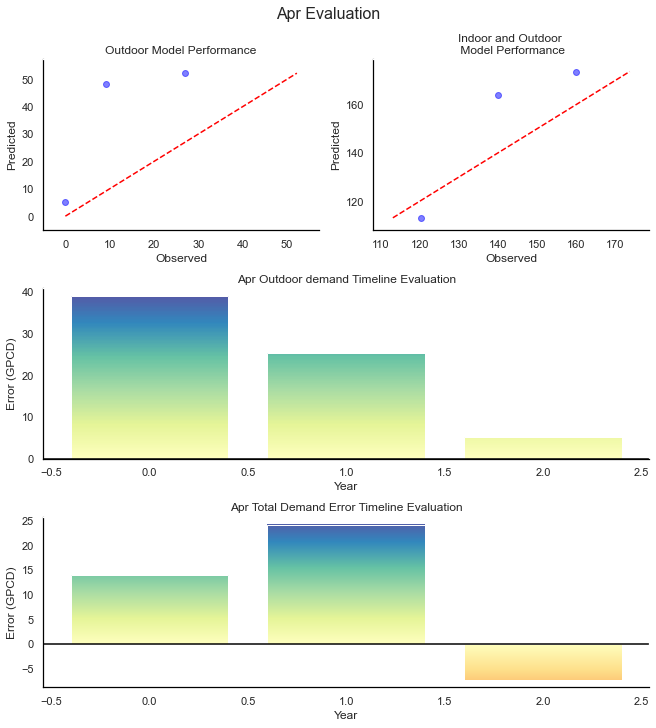

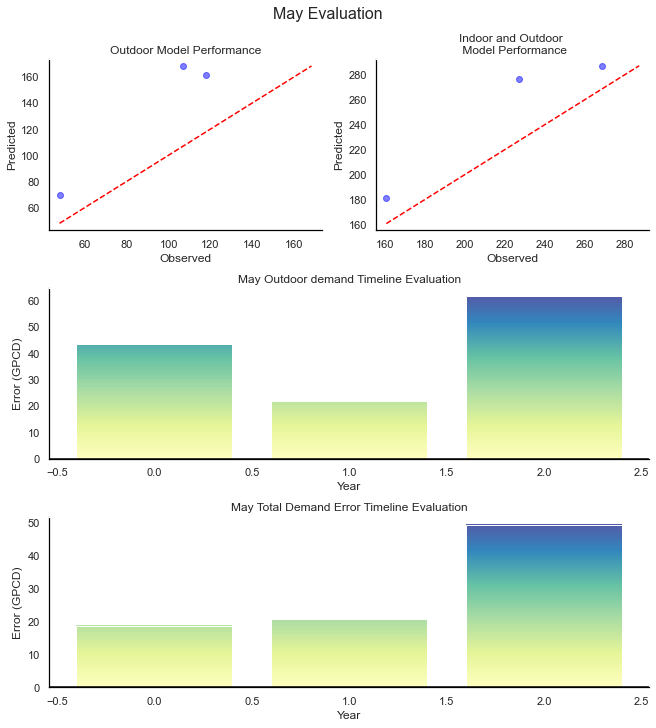

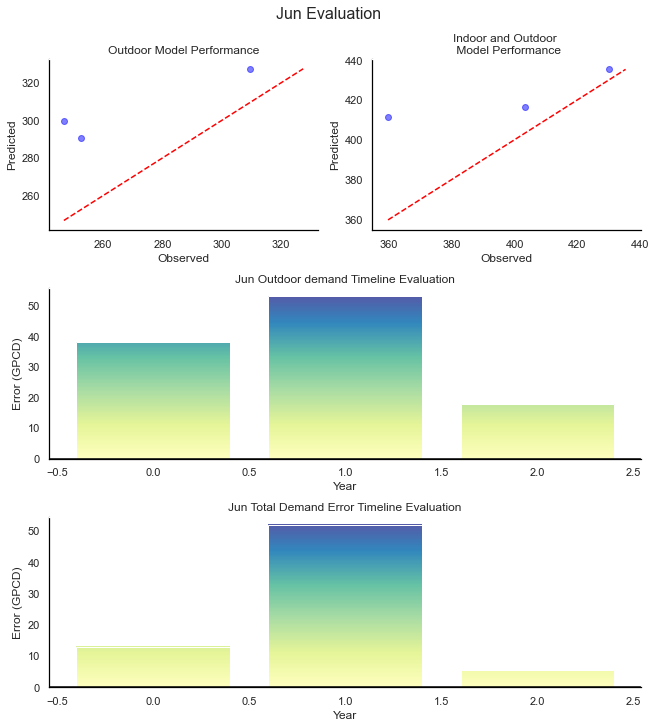

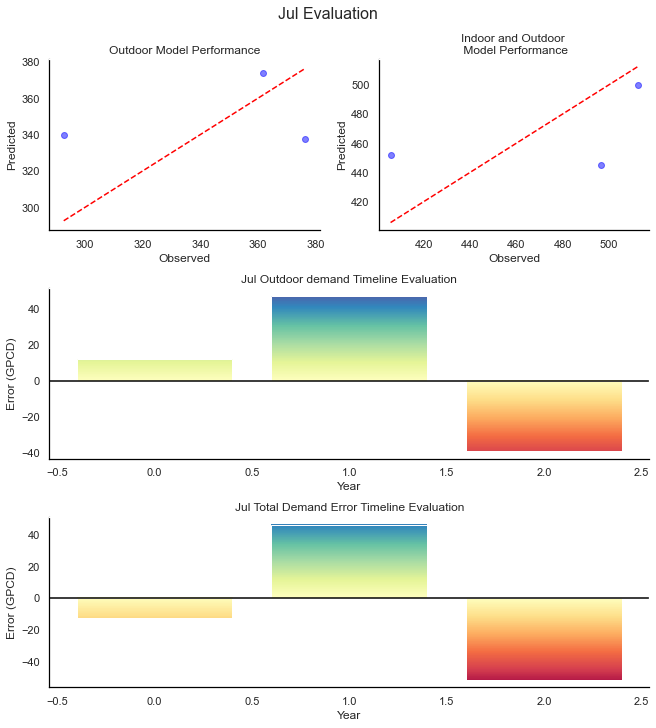

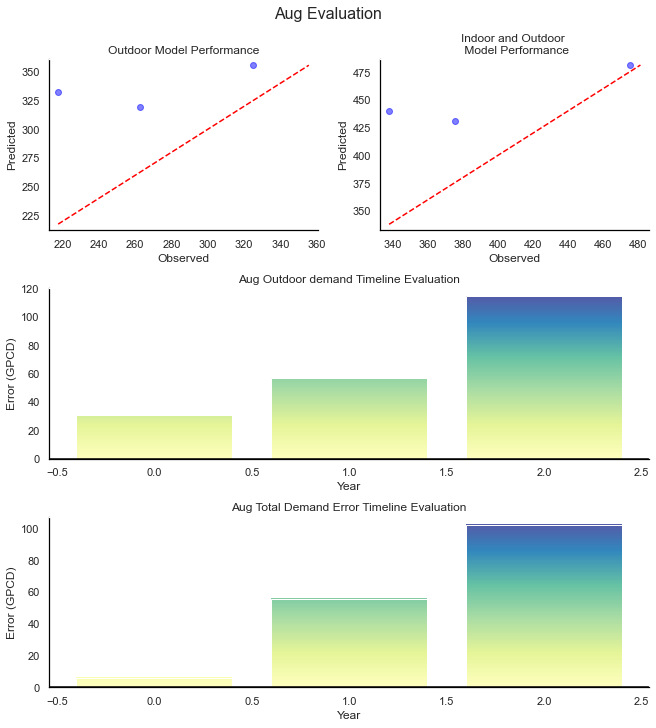

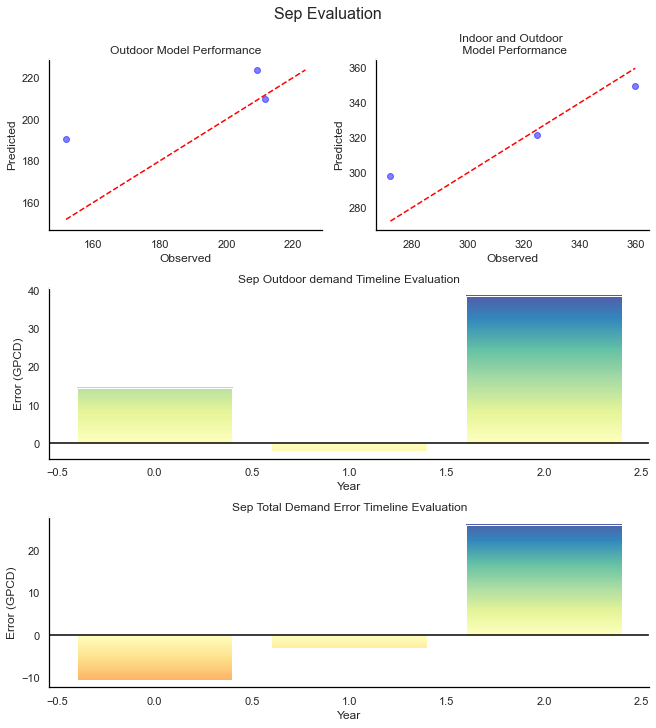

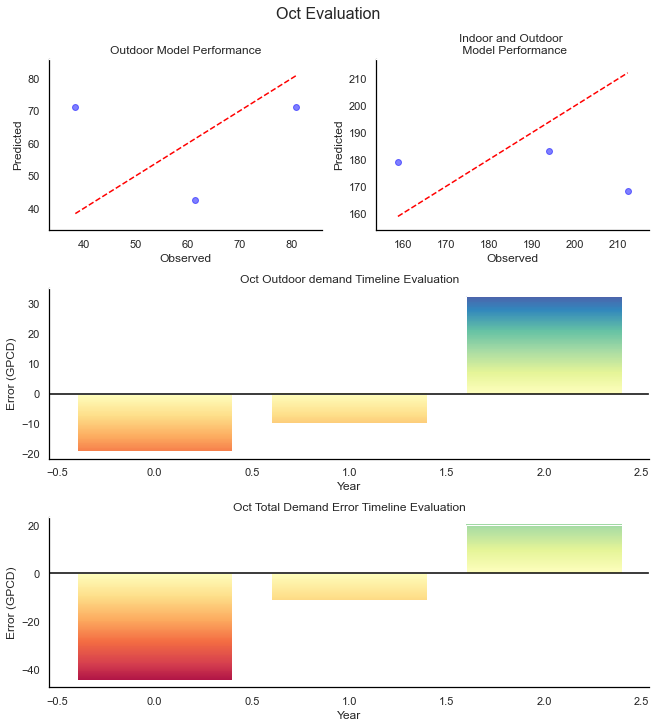

C:\Users\Ryan\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


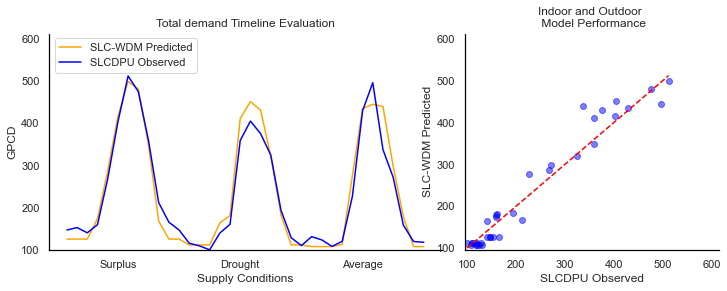

In [15]:
#Separate indoor and outdoor prediction months
Outdoor_Months=['Apr', 'May' , 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']
IndoorMonths = ['Jan', 'Feb', 'Mar', 'Nov', 'Dec']



slc_val=copy.deepcopy(slc_test)
# calibrate and predict with the outdoor model
pbar = ProgressBar()
for i in pbar(Outdoor_Months):
    
    PerfDF  = RFR_OutdoorDemandModel(slc_train[i],slc_test[i], i, 'RFR_Models')
    
    colrem = slc_test[i].columns
    slc_val[i] = slc_val[i].reset_index(drop=True)
    slc_val[i] = pd.concat([slc_val[i], PerfDF], axis=1, join="inner")
    slc_val[i] = slc_val[i].set_index('Date')
    slc_val[i] = slc_val[i].drop(columns=colrem)

#Calibrate and predict with the indoor model
for i in IndoorMonths:
    slc_val = Indoor_Demand_Model(slc_val, i)


#Put it all together and display the results
#Demand_Forecast(slc_val)
df = pd.DataFrame()
Pred_Obs = Demand_Forecast(slc_val, True, df, 'y_pred_tot', 'y_test_tot', 'GPCD', 'Long_term_pred_gpcd', 'SLC-WDM')

In [ ]:
#save predictions
np.save('RFR_Models/Slc_Pred.npy', slc_val)

In [21]:
#save predictions
slc_val = np.load('RFR_Models/Slc_Pred.npy', allow_pickle = True).item()

yes
Total R2 is  0.942712866403471
Total MAE is  22.686154498499704
Total RMSE is  30.59692714279257
Total MAPE is  10.516310077140144


<ipython-input-30-895b8f9ae21d>:103: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')


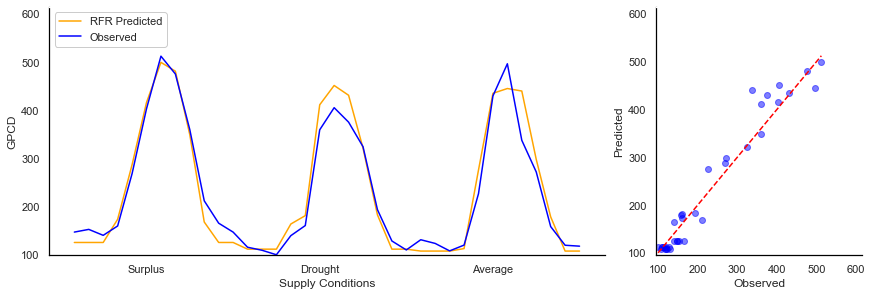

In [31]:
#Put it all together and display the results
#Demand_Forecast(slc_val)
df = pd.DataFrame()
Pred_Obs = Demand_Forecast(slc_val, True, df, 'y_pred_tot', 'y_test_tot', 'GPCD', 'RFR_Seasonal_pred_gpcd', 'RFR')

In [15]:
from pandas.tseries.offsets import MonthEnd
cols = ['y_test_tot', 'y_pred_tot']
monthorder = ['Jan', 'Feb' , 'Mar', 'Apr', 'May', 'Jun' , 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
Pred_Obs = Pred_Obs[cols]

#input population into DF to calculate total water demands.
Population = []
UR_gpcd = []
slc_pred=copy.deepcopy(slc)
for i in monthorder:
    slc_train[i] = copy.deepcopy(slc[i].loc[:2010])
    slc_pred[i] = slc_pred[i].loc[2015:]
    slc_pred[i]['UR_gpcd'] = np.mean(slc_train[i]['Obs_gpcd'])
    Population.append(np.round(slc_pred[i]['Population'],0))
    
UR=pd.DataFrame()
for i in slc_pred:
    slc_pred[i]= pd.DataFrame(slc_pred[i]['UR_gpcd'])
    slc_pred[i]=slc_pred[i].reset_index()
    slc_pred[i]['M'] = datetime.datetime.strptime(i, "%b").month
    slc_pred[i]['D'] = 1
    slc_pred[i]['Date'] = pd.to_datetime(slc_pred[i].Year*10000+slc_pred[i].M*100+slc_pred[i].D,format='%Y%m%d')+MonthEnd(1)
    slc_pred[i].index = slc_pred[i].Date
    slc_pred[i]=slc_pred[i].drop(columns = ['M', 'D', 'Date', 'Year'])
    UR = UR.append(slc_pred[i])

UR=UR.sort_index()
Population = np.sort(np.array(Population).reshape(36,))

#place in to prediction df
Pred_Obs['Population'] = Population
Pred_Obs['UR_gpcd'] = UR['UR_gpcd']



#Now we can form some acre-feet predictions.
gpcd=['y_test_tot','y_pred_tot','UR_gpcd']
for i in gpcd:
    Pred_Obs[i+str('_AF')] = Pred_Obs[i]*Pred_Obs['Population']*9.33454e-5

    
remcol=['y_test_tot','y_pred_tot','UR_gpcd', 'Population']
Ann_Eval = Pred_Obs.drop(columns = remcol).copy()
Ann_Eval = Ann_Eval.resample('Y').sum()



no
Total R2 is  0.9419716482520051
Total MAE is  734.3629178694044
Total RMSE is  993.1935741775599
Total MAPE is  10.516310077140147


<ipython-input-12-359c24012985>:103: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')


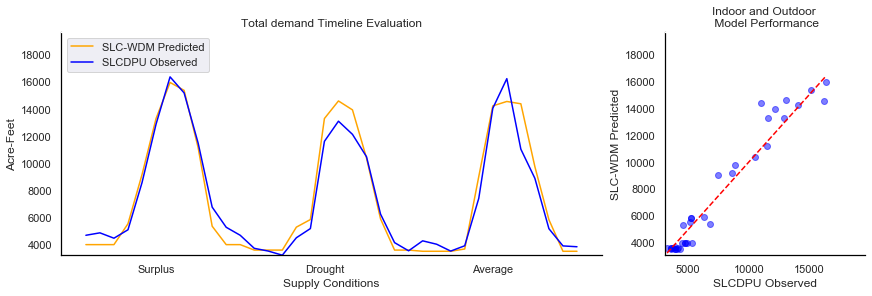

In [16]:
Pred_AF = Demand_Forecast(slc_val, False, Pred_Obs, 
            'y_pred_tot_AF', 'y_test_tot_AF', 'Acre-Feet', 'RFR_Seasonal_term_pred_AF', 'RFR')

no
Total R2 is  0.6283371213177069
Total MAE is  63.03597863247863
Total RMSE is  77.93344228795345
Total MAPE is  30.78863740465362


<ipython-input-12-359c24012985>:103: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')


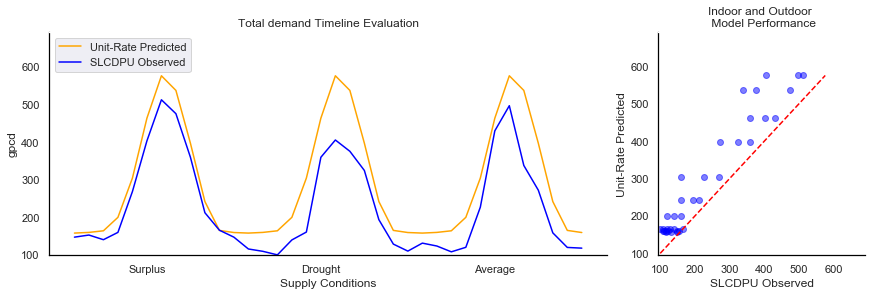

In [17]:
Pred_UR_GPCD = Demand_Forecast(slc_val, False, Pred_Obs, 'UR_gpcd',
                'y_test_tot', 'gpcd', 'Seasonal_pred_UR_gpcd', 'Unit-Rate')

In [18]:
Pred_UR_GPCD['StationaryError'] = ((Pred_UR_GPCD['UR_gpcd']-Pred_UR_GPCD['y_test_tot'])/Pred_UR_GPCD['y_test_tot'])*100
Pred_UR_GPCD['RFRError'] = ((Pred_UR_GPCD['y_pred_tot']-Pred_UR_GPCD['y_test_tot'])/Pred_UR_GPCD['y_test_tot'])*100
Pred_UR_GPCD['StationaryErrorAF'] = Pred_UR_GPCD['UR_gpcd_AF']-Pred_UR_GPCD['y_test_tot_AF']
Pred_UR_GPCD['RFRErrorAF'] = Pred_UR_GPCD['y_pred_tot_AF']-Pred_UR_GPCD['y_test_tot_AF']
Evalcol = ['y_test_tot_AF', 'y_pred_tot_AF', 'StationaryError','RFRError', 'StationaryErrorAF', 'RFRErrorAF']
Eval = Pred_UR_GPCD[Evalcol]

Annual = Eval.resample('Y').sum()
Annual['S_Perror'] = Annual['StationaryErrorAF']/Annual['y_test_tot_AF']*100
Annual['RFR_Perror'] = Annual['RFRErrorAF']/Annual['y_test_tot_AF']*100
Annual

,y_test_tot_AF,y_pred_tot_AF,StationaryError,RFRError,StationaryErrorAF,RFRErrorAF,S_Perror,RFR_Perror
Date,,,,,,,,
2015-12-31,100550.276769,96041.403290,139.858017,-87.788392,12207.162705,-4508.873479,12.140357,-4.484198
2016-12-31,81646.774954,87444.477996,512.522236,62.752961,32430.298904,5797.703042,39.720245,7.100958
2017-12-31,86505.457871,89205.005195,455.384862,9.392539,28891.579705,2699.547324,33.398563,3.120667


In [19]:
Eval

,y_test_tot_AF,y_pred_tot_AF,StationaryError,RFRError,StationaryErrorAF,RFRErrorAF
Date,,,,,,
2015-01-31,4709.274282,4020.242564,7.342278,-14.631378,345.767994,-689.031718
2015-02-28,4888.568674,4020.242564,4.579880,-17.762379,223.890584,-868.326110
2015-03-31,4493.545735,4020.242564,16.816118,-10.532955,755.639941,-473.303171
2015-04-30,5114.524352,5557.657356,24.996996,8.664208,1278.477435,443.133003
2015-05-31,8583.758986,9176.888274,13.335806,6.909901,1144.713444,593.129288
2015-06-30,12890.020382,13307.081413,14.946044,3.235534,1926.548117,417.061030
2015-07-31,16379.389681,15968.633837,12.453508,-2.507760,2039.808677,-410.755844
2015-08-31,15197.197243,15385.678067,13.006844,1.240234,1976.675810,188.480824
2015-09-30,11502.006931,11167.055626,10.339270,-2.912112,1189.223590,-334.951305


no


<ipython-input-14-01d5912c7083>:92: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/RFR' +str(plotname)+'.pdf')
<ipython-input-14-01d5912c7083>:103: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')
C:\Users\Ryan\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


Total R2 is  0.6235333383547133
Total MAE is  2043.3946037944281
Total RMSE is  2529.7467407378826
Total MAPE is  30.771253177933406


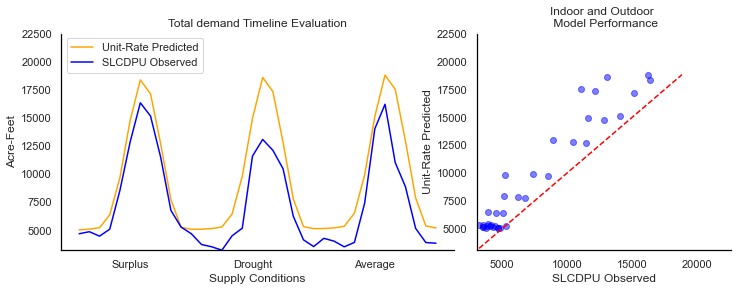

In [20]:
Pred_UR_AF = Demand_Forecast(slc_val, False, Pred_Obs, 'UR_gpcd_AF', 
                             'y_test_tot_AF', 'Acre-Feet', 'Seasonal_pred_UR_AF', 'Unit-Rate')

In [46]:
'''I am putting a hard code on the limits here to make both figure have same color scale'''

plt.rcParams["axes.grid"] = False
plt.rcParams["axes.facecolor"] ='white'
#plt.rcParams["axes.edgecolor"]['bottom'] = 'black'

def gradientbars_sliced(bars, ymin, ymax):
    ax = bars[0].axes
    xmin, xmax = ax.get_xlim()
 #   ymin, ymax = ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.linspace(y, y + h, 256).reshape(256, 1)
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=0, origin='lower',
                  vmin= - max(np.abs(ymin), ymax), vmax=max(np.abs(ymin), ymax), cmap='Spectral_r')
    ax.axis([xmin, xmax, ymin, ymax])


TypeError: can only concatenate str (not "int") to str

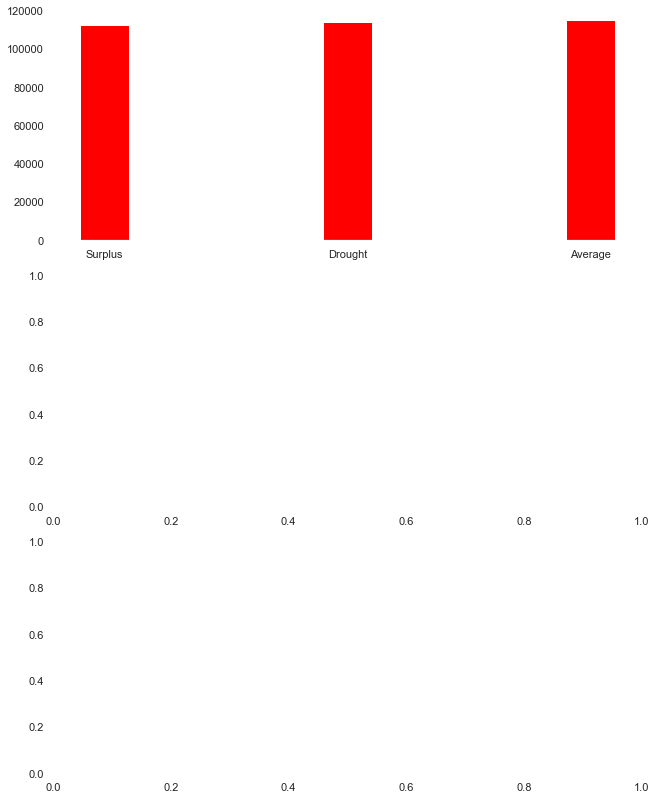

In [51]:
#Reduce width to increase space between bars
width = .2
widthM = 1
titlesize = 14

Ann_Eval['Supply'] = ['Surplus', 'Drought', 'Average']
Ann_Eval.index = Ann_Eval['Supply']

DayDF = Ann_Eval

fig, ax = plt.subplots(3,1, constrained_layout=True)
fig.set_size_inches(9,11)
DayDF['Error_SLC_WDM'] = DayDF.y_pred_tot_AF-DayDF.y_test_tot_AF
DayDF['Error_UR'] = DayDF.UR_gpcd_AF-DayDF.y_test_tot_AF

#save this df to load into MLR file for comparision figure
DayDF.to_excel('RFR_Models/RFR_Ann_Comp.xlsx')


#Annual Figure

ax[0].bar(DayDF.Supply, DayDF.UR_gpcd_AF, width=width, 
    color='red', label='Base')
ax[0].bar(DayDF.Supply+1, DayDF.y_pred_tot_AF, width=width, 
    color='orange', label='RFR')
ax[0].bar(DayDF.Supply, DayDF.y_test_tot_AF, width=width, 
    color='blue', label='Observed')
ax[0].set_ylim(0,max(max(Ann_Eval.y_test_tot_AF), max(Ann_Eval.y_pred_tot_AF),max(Ann_Eval.UR_gpcd_AF))*1.2)
#ax.annotate('Max Extra DC use: '+str(np.round(np.max(DayDF.ExtraDC),1))+'MGD', 
 #              xy=(DayDF.index[269], 150))
#ax.annotate('Max Daily DC use: '+str(np.round(np.max(DayDF.SLCDPU_DC_Water_Use),1))+'MGD', 
 #              xy=(DayDF.index[269], 130))
ax[0].legend(loc = 'upper left')
ax[0].set_ylabel('Acre-Feet')
ax[0].set_title(' Comparison of Seasonal Forecasts vs Observed', size = titlesize)
ax[0].spines['bottom'].set_color('black')
ax[0].spines['left'].set_color('black')


Error_UR = ax[1].bar(DayDF.index, DayDF.Error_UR, width=width, 
    color='red', label='Base')
ax[1].set_ylabel('Acre-Feet')
ax[1].set_title('Base: Difference From The Observed', size = titlesize)
gradientbars_sliced(Error_UR, min(min(DayDF.Error_UR), min(DayDF.Error_SLC_WDM)),
                    max(max(DayDF.Error_UR), max(DayDF.Error_SLC_WDM)))
ax[1].spines['bottom'].set_color('black')
ax[1].spines['left'].set_color('black')



Error_SLC_WDM = ax[2].bar(DayDF.Supply, DayDF.Error_SLC_WDM, width=width, 
    color='red', label='Base')
ax[2].set_ylabel('Acre-Feet')
ax[2].set_title('RFR: Difference From The Observed', size = titlesize)
gradientbars_sliced(Error_SLC_WDM, min(min(DayDF.Error_UR), min(DayDF.Error_SLC_WDM)),
                    max(max(DayDF.Error_UR), max(DayDF.Error_SLC_WDM)))
ax[2].spines['bottom'].set_color('black')
ax[2].spines['left'].set_color('black')

fig.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/MLR_MLP_RFR_Base.pdf')